TNET

This is where my lack of experience really becomes apparent.  I've worked with standard CNNs before, but nothing like a UNet.  I copied the UNet from https://medium.com/srm-mic/a-gentle-introduction-to-u-net-fc4afd12a893.  This version uses VGG16 layers which is standard for these kinds of problems.  I was also able to read and understand the code behind the UNet, so it made a lot more sense than other places I found.  The main benefit I gathered from reading how other people handled the architecture was the use of helper functions, which significantly clean up the code.  I definitely would have attempted to do this from scratch had I not read through other people's attempts.

In [1]:
# Importing the required libraries

import os
from os import path
from tqdm import tqdm

import cv2
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torch.utils.tensorboard import SummaryWriter

# I was not particularly happy with the gamma correction and it's impact on the brightness so I decided to include a brightness adjustment
# to the dataset, courtesy of pytorch's dataloader functionality.  I also apply normalization, which makes the process of learning much easier for the neural network

img_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.75)
    ,transforms.ToTensor()
    ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

DATASET

The biggest mistake I've made before when it comes to handling image datasets in pytorch is that I turned the images into numpy arrays and stuffed them into a dataframe.  As it turns out, the dataset can be as simple as the name of the file and you can turn that into a PIL image whenever the neural network needs to process it.  The best part of the dataloader is that it automatically shuffles the images and keeps them in batches for you.

You can see below that I tested out the dataset by pulling a batch size of 8 images and their appropriate target.  I turned off the normalize transformation for this because that would not make intuitive sense to us.  Overall, I'm very happy with the way the custom dataset turned out.

In [2]:
class T_ImageDataset(Dataset):

    def __init__(self,test=False,transform=None):
        self.root = path.abspath(path.curdir)
        self.transform = transform
        self.traintest = 'test' if test else 'train'
        self.data = os.listdir(self.root + f'/data/{self.traintest}/')
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,index):

        if torch.is_tensor(index):
            index = index.tolist()

        item = Image.open(self.root + f'/data/{self.traintest}/' + self.data[index])
        target = Image.open(self.root + f'/trimap/{self.traintest}/' + self.data[index].replace("data","trimap"))
        
        if self.transform:
            item = self.transform(item)
            target = transforms.ToTensor()(target)*255

        
        return item, target

In [3]:
trainset = T_ImageDataset(test=False,transform=img_transform)

trainloader = DataLoader(
    trainset,
    batch_size=1,
    shuffle=True
    )

In [15]:
testset = T_ImageDataset(test=True,transform=img_transform)

testloader = DataLoader(
    testset,
    batch_size=1,
    shuffle=True
    )

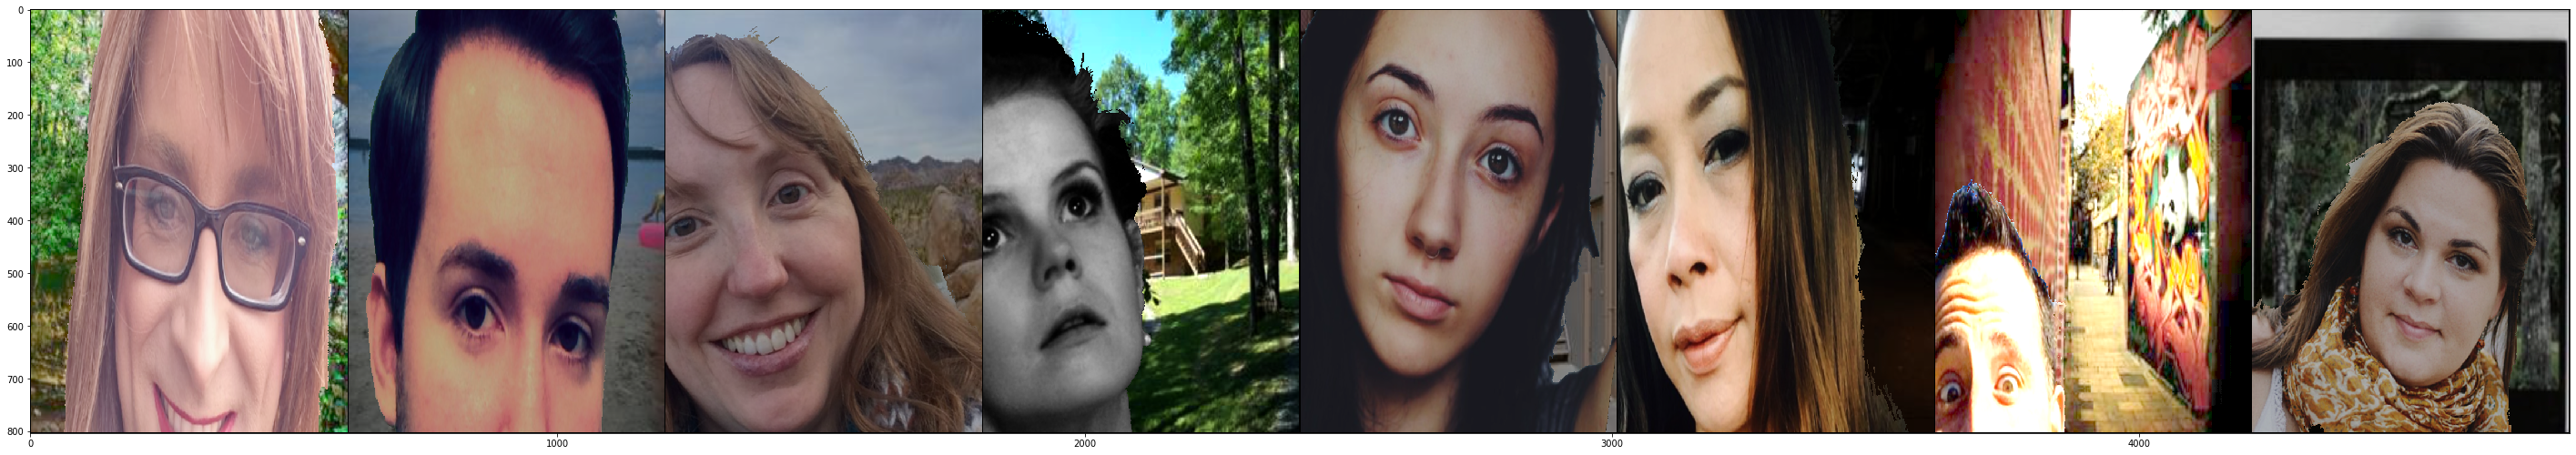

In [5]:
sample = next(iter(trainloader))
grid = torchvision.utils.make_grid(sample[0],nrow=8)
plt.figure(figsize=(50,50))
plt.imshow(grid.numpy().transpose(1,2,0))

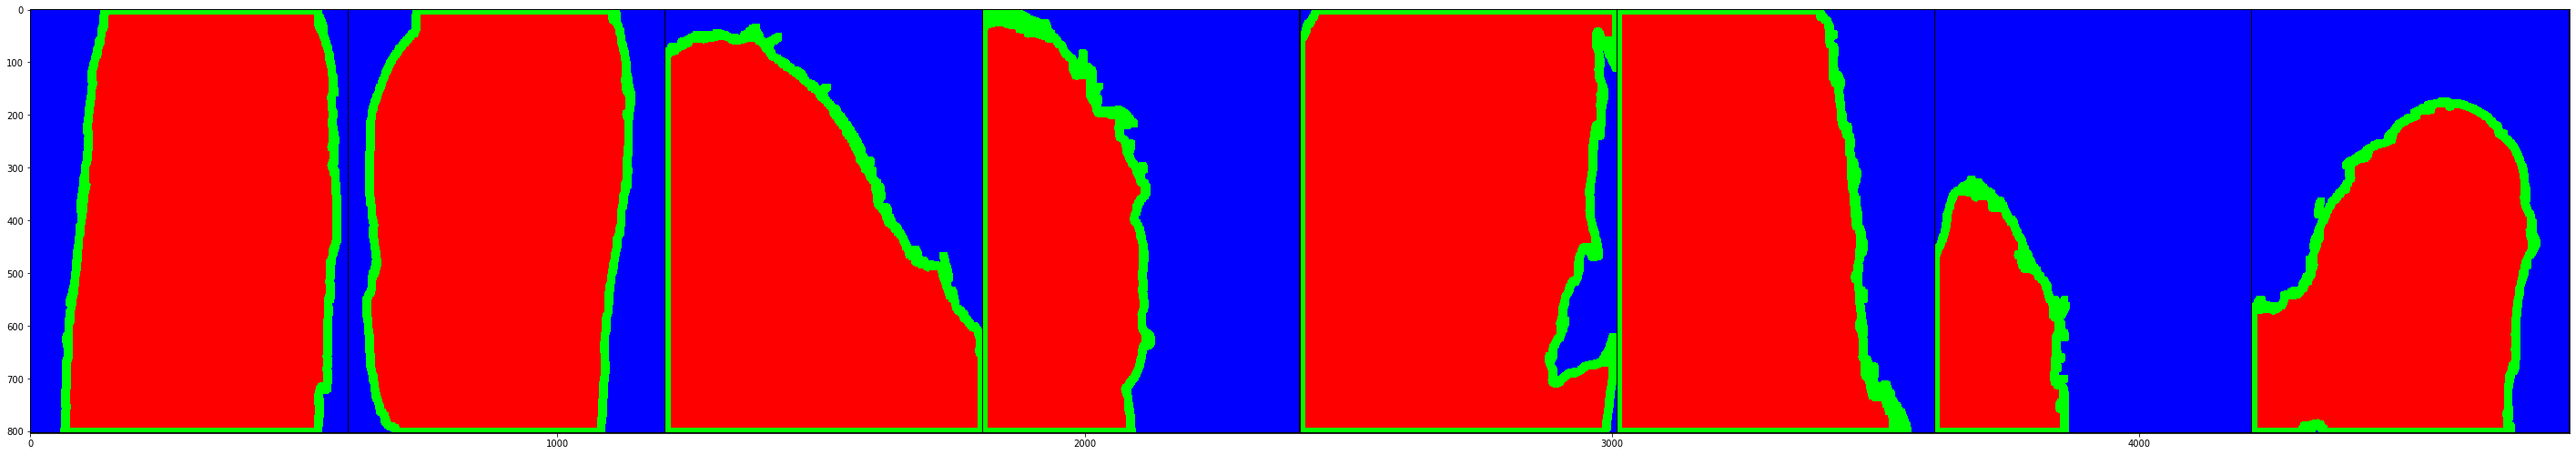

In [6]:
grid = torchvision.utils.make_grid(sample[1],nrow=8)
plt.figure(figsize=(50,50))
plt.imshow(grid.numpy().transpose(1,2,0))

UNET

There are a few changes that I had to make to the UNet I had found.  The first was easy, the writer had forgotten to concatenate the old convolution with the current one in the Up class.  This was probably just a typo that was corrected in the final product.  Next, I ran into an issue with memory.  I have a GTX 1050 Ti GPU, but it was not capable of handling the entirety of the network.  Even when pushing the batch size down to 1, I still ran out of memory.

There were two major adjustments that allowed the network to train.  The first involved changing the DoubleConv class to a single convolution/batchnorm/relu pair.  The second was to snip the last pair of Down and Up layers in the middle.  Double convolution allows for finer detail and processing per UNet Layer but each UNet layer allows for a broader global context.  I decided that since most portraits had similar shape and locations and that the big issue with portraits is the small details, that I would lose the middle pair of layers in favor of having double convolutions.

In testing both, I did not find significant differences after one epoch of training.  However, even after training for a few epochs, there was a wispiness around the borders for a fair amount of images that did not go away.

![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/Wispy.PNG?raw=true)

This lead me to research loss functions.  However, as it turned out, the biggest impact would be to softmax on dimension 1 so that the class values because probabilities distributions.  This significantly helps the neural network create class predictions for foreground, background, and uncertainty because the network can work with relative numbers instead of trying to make the values be exactly 0 or 1.  Looking ahead, instead of softmaxing the alpha matte prediction, I applying a sigmoid (applying softmax to one value automatically converts it to a 1).

In [4]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [5]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [6]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat((x1,x2),1)
        x = self.conv(x)
        return x

In [7]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256,256)
        self.up1 = Up(512, 128, bilinear)
        self.up2 = Up(256, 64, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        


    def forward(self, x):
        
        
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x = self.down3(x3)
        x = self.up1(x, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        
        if logits.shape[1]>1:
            logits = F.softmax(logits,dim=1)
            
        else:
            logits = torch.sigmoid(logits)

        return logits

LOSS FUNCTIONS

Even though applying a softmax significantly improved the results, I'm glad that I looked into loss functions.  I was originally using the standard MSE loss that is given by pytorch.  This is a pixel wide square of the difference between predicted and ground truth, for each channel.

![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/MSE.PNG?raw=true)

Compositional loss, which I've defined below, is the same thing except for you had a small coefficient, epsilon, and then take the square root.  It's essentially the absolute value of the difference instead of the square (similar to the difference between L1 and L2).  The dice loss, however, is slightly different.  It applies the mask to the prediction, and then performs a loss function.

![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/Dice.PNG?raw=true)

This is extremely useful for unbalanced datasets.  Medical imaging is the best example for this because small tumors or other things in xrays are very small when compared to the entirety of the image.  My intuition was that the border or uncertainty region would also suffer from being undersampled.  This is because for all images, the second channel ground truth will be composed of mostly 0's.  This will bias the neural network into predicting 0's.  However, my thought was that the uncertainty region was more important than the other two when it comes to predicting foreground.  Therefore, in removing the negative affect of not appearing as much, the neural network should be able to learn the boundary region much more effectively.

![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/DicePicture.PNG?raw=true)

This was a fantastic illustration that does a great job of visually explaining dice loss that I found here https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b.

In [9]:
class DiceLoss(nn.Module):

    def __init__(self) -> None:
        super(DiceLoss, self).__init__()
        self.epsilon: float = 1e-6
        self.dims = (1,2,3)    
            
    def forward(self,output,target):
        

        intersection = torch.sum(output * target, self.dims)
        cardinality = torch.sum(output + target, self.dims)

        dice_score = 2. * intersection / (cardinality + self.epsilon)
        
        return torch.mean(torch.tensor(1.) - dice_score)  

In [9]:
class CompositionalLoss(nn.Module):
    
    
    def __init__(self) -> None:
        super(CompositionalLoss, self).__init__()
        self.epsilon: float = 1e-6
        self.dims = (1,2,3) 
        
    def forward(self,output,target):
        
       
        loss = torch.pow(torch.pow(output - target,2) + self.epsilon,0.5)
        
        return torch.mean(loss)

TRAINING

I was initially going to train both TNet and MNet together but due to memory limitations I am forced to train them separately.  Since I can only handle a batch size of 1, the loss is not really reliable as it stochastically jumps around.  I could average the loss but I did not want to test the capabilities of the memory.  Finally, because each person's face is repeated 10-20 times, I was super worried about overfitting.  However, I trained each model for 4 epochs, saving after each one, and compared the results on test images.  While there was some variability, the networks seemed to improve and the 4th version seemed to be the best.  The biggest gap was between epoch 1 and 2, with the last 3 not having significant impact.

In [10]:
EPOCHS = 10
LR = 0.001
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
CURRENT_DIR = path.abspath(path.curdir)

In [11]:
TNet = UNet(3,3)
TNet.load_state_dict(torch.load(CURRENT_DIR + '/Models/Versions/COMP/TNET COMP v4'))
TNet.to(DEVICE)
optimizer = optim.Adam(TNet.parameters(),lr=LR)
# loss_function = DiceLoss()
# loss_function = nn.MSELoss()
loss_function = CompositionalLoss()

In [12]:
def train(net,trainloader):
    for epoch in range(EPOCHS):
        
        avg_loss = 0
        
        for data in tqdm(trainloader): 
            
            net.zero_grad()
            
            images, trimaps = data[0].float().to(DEVICE), data[1].float().to(DEVICE)
#             images, trimaps = images.float(), trimaps.float()

            outputs = net(images)
            loss = loss_function(outputs,trimaps)
            loss.backward()
            optimizer.step()
            
            images.cpu()
            trimaps.cpu()          

            avg_loss += loss
            
        avg_loss /= 20592    

        print(f"Epoch: {epoch+1}. Avg Loss: {avg_loss}.")
        
        torch.save(TNet.state_dict(),CURRENT_DIR + f'/Models/TNET COMP v{epoch+5}')
    

In [13]:
train(TNet,trainloader)

100%|██████████████████████████████████████████████████████████████████████████| 20592/20592 [4:15:01<00:00,  1.35it/s]


Epoch: 1. Avg Loss: 0.022144582122564316.


100%|██████████████████████████████████████████████████████████████████████████| 20592/20592 [4:07:48<00:00,  1.38it/s]


Epoch: 2. Avg Loss: 0.020833048969507217.


100%|██████████████████████████████████████████████████████████████████████████| 20592/20592 [4:07:40<00:00,  1.39it/s]


Epoch: 3. Avg Loss: 0.01916147768497467.


100%|██████████████████████████████████████████████████████████████████████████| 20592/20592 [4:10:47<00:00,  1.37it/s]


Epoch: 4. Avg Loss: 0.01806648261845112.


100%|██████████████████████████████████████████████████████████████████████████| 20592/20592 [4:09:39<00:00,  1.37it/s]


Epoch: 5. Avg Loss: 0.017174910753965378.


100%|██████████████████████████████████████████████████████████████████████████| 20592/20592 [4:12:23<00:00,  1.36it/s]


Epoch: 6. Avg Loss: 0.01628432236611843.


100%|██████████████████████████████████████████████████████████████████████████| 20592/20592 [4:07:14<00:00,  1.39it/s]


Epoch: 7. Avg Loss: 0.015941930934786797.


100%|██████████████████████████████████████████████████████████████████████████| 20592/20592 [4:07:33<00:00,  1.39it/s]


Epoch: 8. Avg Loss: 0.015101847238838673.


100%|██████████████████████████████████████████████████████████████████████████| 20592/20592 [4:10:12<00:00,  1.37it/s]


Epoch: 9. Avg Loss: 0.01459620613604784.


100%|██████████████████████████████████████████████████████████████████████████| 20592/20592 [4:09:09<00:00,  1.38it/s]


Epoch: 10. Avg Loss: 0.014040792360901833.


RESULTS

So, the results are not as good as I would have liked.  It's hard to say how well a network can perform given that I've adding complicated backgrounds into each photo.  The network does a good job most of the time (~80%).  I think that this network is perfectly fine with 'easy' backgrounds and will have little trouble with most of the celebrity dataset.  However, I still look forward to testing this on the unique test cases I highlighted in the first jupyter notebook (multiple people, hats, distortions in the images).


It's clear that additional epochs are useful, but due to my skepticism over overfitting and how long a single epoch takes (~8 hours) I do not want to spend too much time on this.  When comparing the different loss functions, the compositional loss recommended by the Semantic Human Matting research paper seems to be the best. There are images where MSE performs really well, but it gets tied up in facial features and is way too sensitive to outliers in the background.  The difference between compositional and dice loss is a little harder to explain.  Both have images where they perform better than the other, but overall I find the mistakes made by compositional loss to be a lot more tolerable.  Surprisingly, compositional loss seems to be much better at finding the overal shape of the person, and slightly worse at granular detail. 

![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/LossComparison.PNG?raw=true)
![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/LossComparison2.PNG?raw=true)

This are two examples where the MSE loss actually performs better than the other two.  This is the best example I could come up with to illustrate the point that compositional loss seems to excel where dice loss is specialized but does not fall into the same traps.  It seems to find the happy medium and will be the loss function I use going forward with the MNet as well.

On another note, in the first example above, it looks like there is a misclassification in the true trimap that gets reflected similarly in my neural network.  I've gone through the training set by hand and have confirmed that this woman is not also in the training set (I had already made sure there were no duplicates but I wanted to be extra sure).  I'm honestly pretty shocked that the TNet made a similar mistake.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


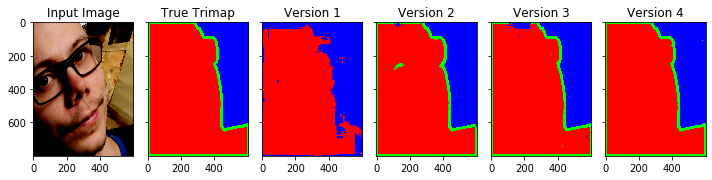

In [30]:
f, axarr = plt.subplots(1,6,figsize=(10,10),sharex=True,sharey=True)

axarr[0].set_title("Input Image")
axarr[1].set_title("True Trimap")
axarr[2].set_title("Version 1")
axarr[3].set_title("Version 2")
axarr[4].set_title("Version 3")
axarr[5].set_title("Version 4")

image, trimap = next(iter(testloader))

axarr[0].imshow(image.cpu().squeeze().numpy().transpose(1,2,0))
axarr[1].imshow(trimap.cpu().squeeze().numpy().transpose(1,2,0))

for i in range(4):
    
    TNet = UNet(3,3).to(DEVICE)
    TNet.load_state_dict(torch.load(CURRENT_DIR + f'/Models/Versions/COMP/TNET COMP v{i+1}'))
    with torch.no_grad():
        output = TNet(image.to(DEVICE)).cpu().squeeze().numpy().transpose(1,2,0)
    TNet.cpu()
    
    axarr[i+2].imshow(output)
    
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


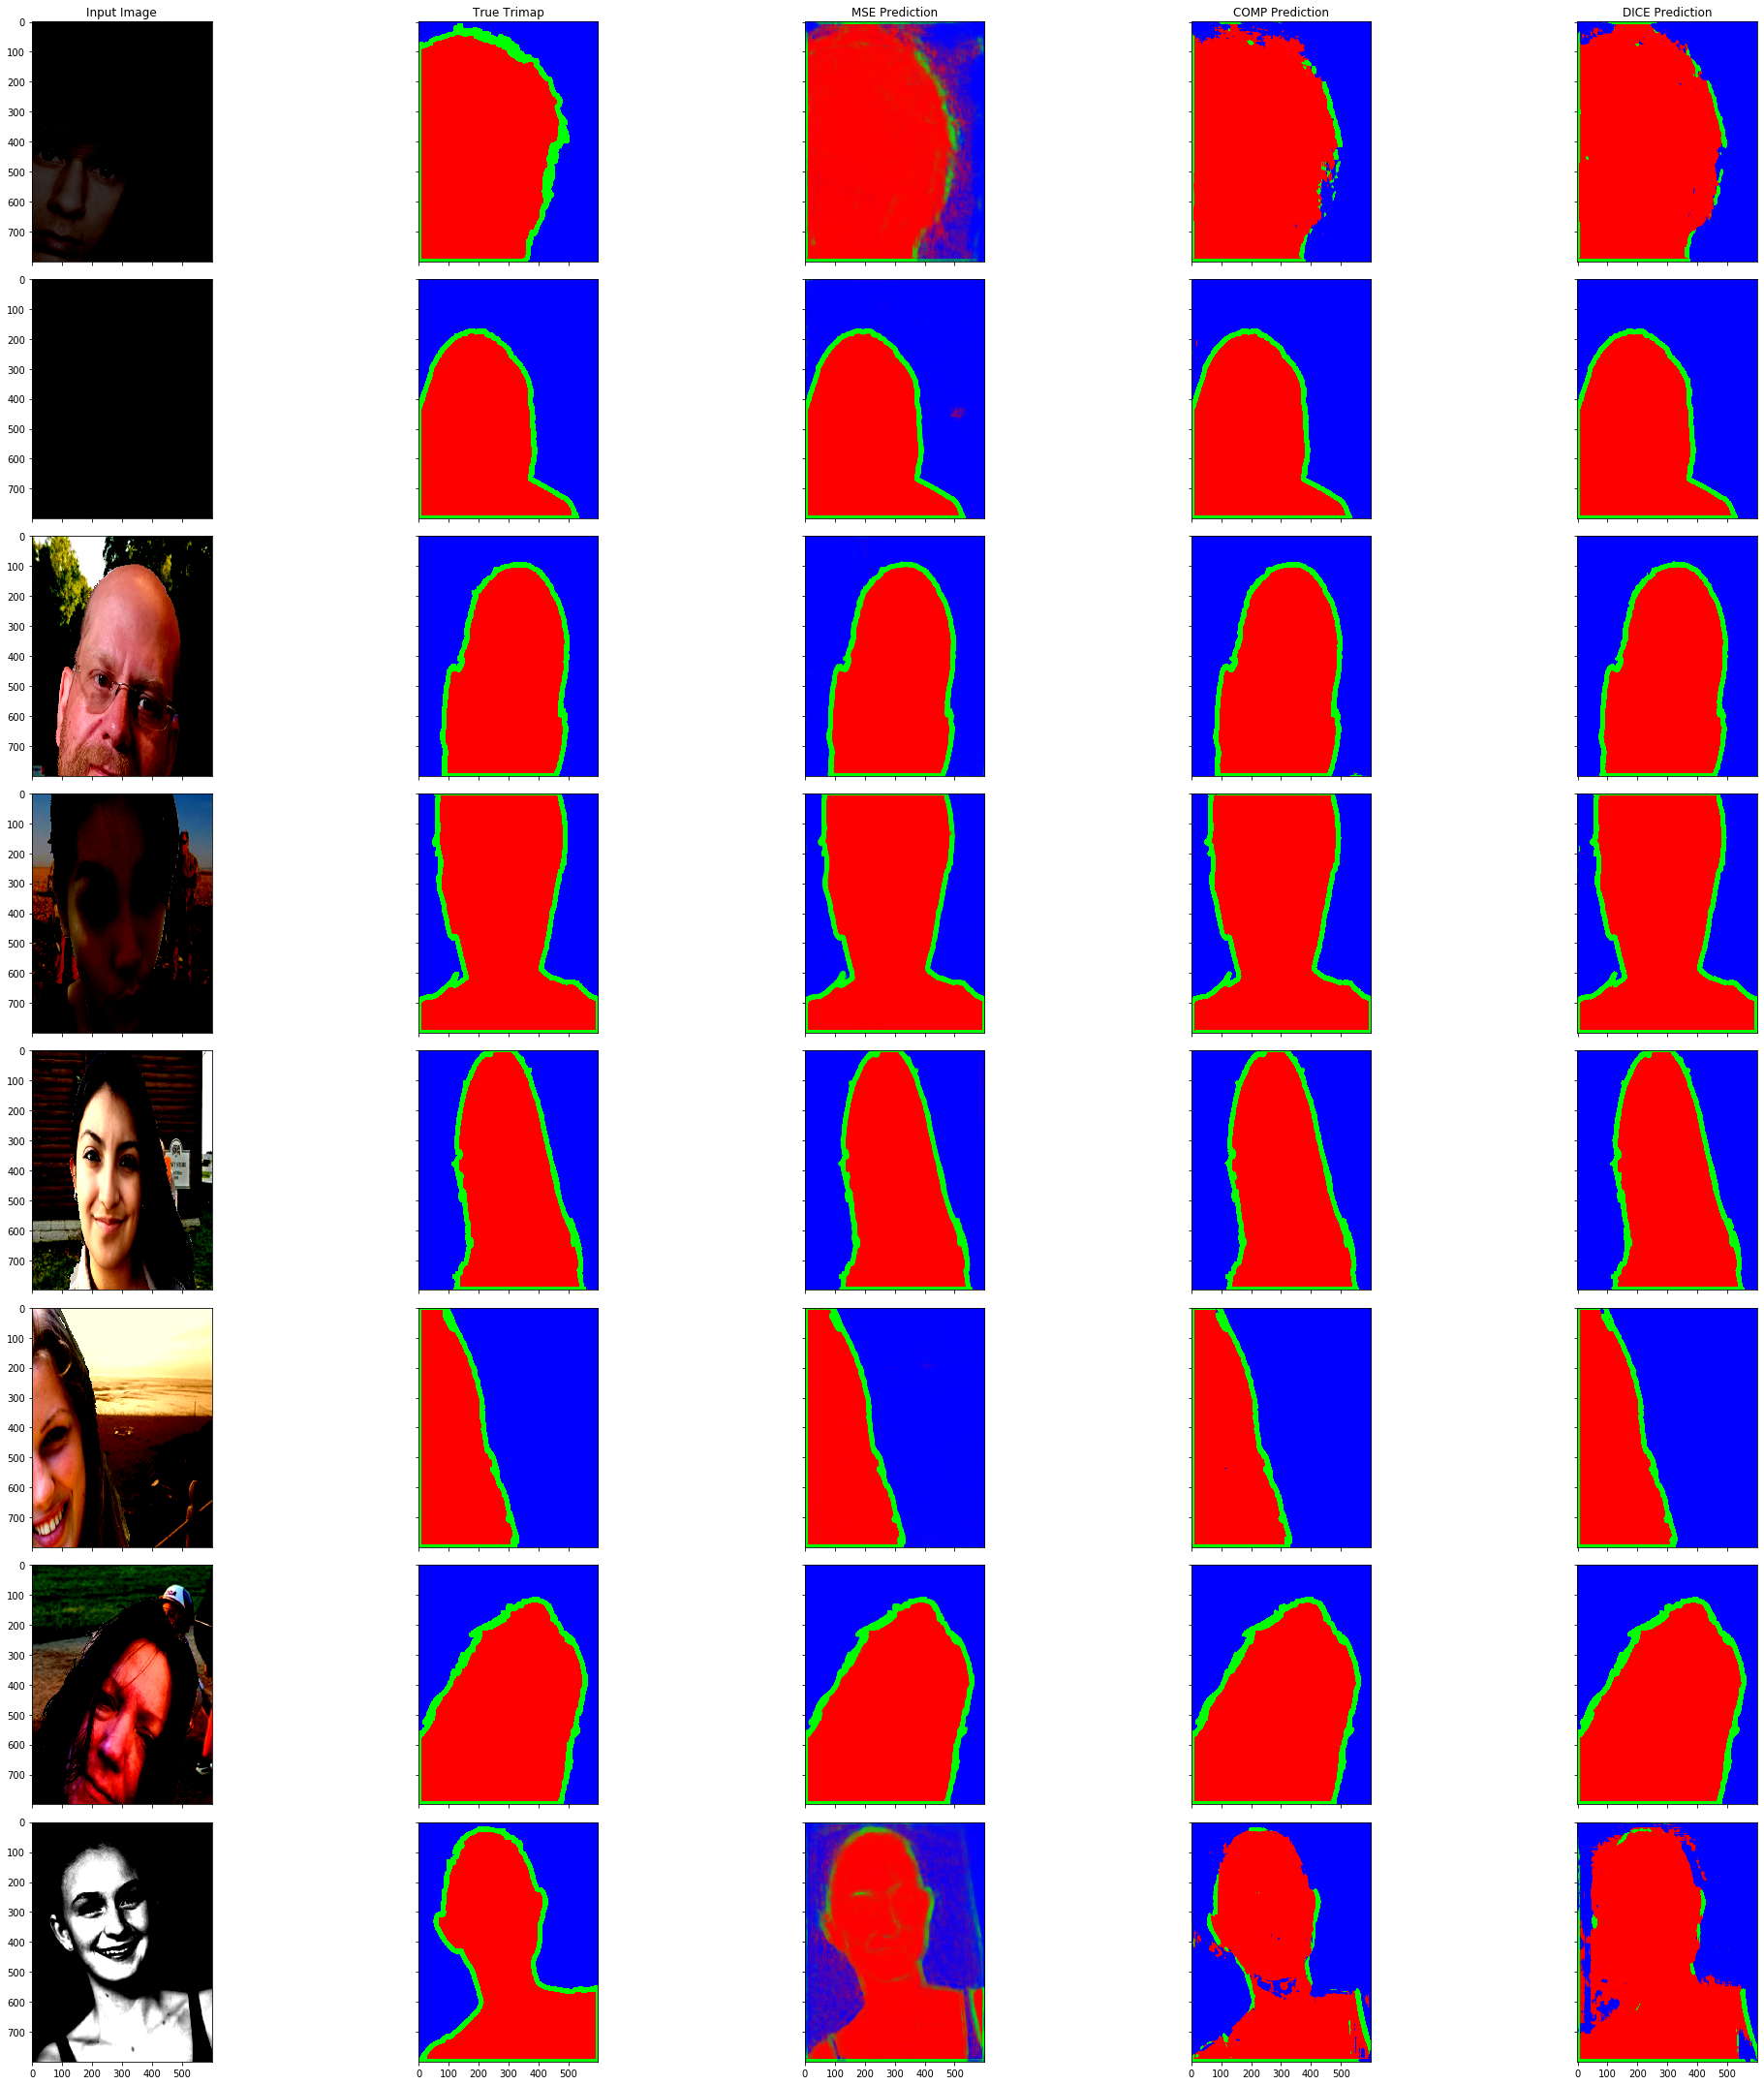

In [25]:
f, axarr = plt.subplots(8,5,figsize=(30,30),sharex=True,sharey=True)

axarr[0,0].set_title("Input Image")
axarr[0,1].set_title("True Trimap")
axarr[0,2].set_title("MSE Prediction")
axarr[0,3].set_title("COMP Prediction")
axarr[0,4].set_title("DICE Prediction")

for i in range(8):
    
    image, trimap = next(iter(testloader))

    COMPNet = UNet(3,3).to(DEVICE)
    COMPNet.load_state_dict(torch.load(CURRENT_DIR + '/Models/Versions/COMP/TNET COMP v4'))
    with torch.no_grad():
        comp_output = COMPNet(image.to(DEVICE)).cpu().squeeze().numpy().transpose(1,2,0)
    COMPNet.cpu()

    DICENet = UNet(3,3).to(DEVICE)
    DICENet.load_state_dict(torch.load(CURRENT_DIR + '/Models/Versions/DICE/TNET DICE v4'))
    with torch.no_grad():
        dice_output = DICENet(image.to(DEVICE)).cpu().squeeze().numpy().transpose(1,2,0)
    DICENet.cpu()

    MSENet = UNet(3,3).to(DEVICE)
    MSENet.load_state_dict(torch.load(CURRENT_DIR + '/Models/Versions/MSE/TNET MSE v4'))
    with torch.no_grad():
        mse_output = MSENet(image.to(DEVICE)).cpu().squeeze().numpy().transpose(1,2,0)
    MSENet.cpu()
    
    axarr[i,0].imshow(image.cpu().squeeze().numpy().transpose(1,2,0))
    axarr[i,1].imshow(trimap.squeeze().numpy().transpose(1,2,0))
    axarr[i,2].imshow(mse_output)
    axarr[i,3].imshow(comp_output)
    axarr[i,4].imshow(dice_output)

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


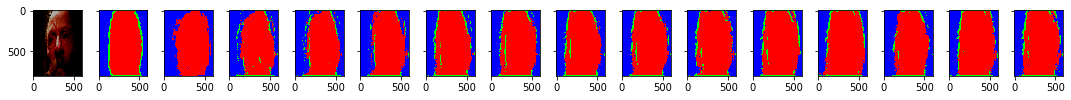

In [32]:
f, axarr = plt.subplots(1,16,figsize=(15,15),sharex=True,sharey=True)

# axarr[0].set_title("Input Image")
# axarr[1].set_title("True Trimap")
# axarr[2].set_title("Version 1")
# axarr[3].set_title("Version 2")
# axarr[4].set_title("Version 3")
# axarr[5].set_title("Version 4")

image, trimap = next(iter(testloader))

axarr[0].imshow(image.cpu().squeeze().numpy().transpose(1,2,0))
axarr[1].imshow(trimap.cpu().squeeze().numpy().transpose(1,2,0))

for i in range(14):
    
    TNet = UNet(3,3).to(DEVICE)
    TNet.load_state_dict(torch.load(CURRENT_DIR + f'/Models/Versions/COMP/TNET COMP v{i+1}'))
    with torch.no_grad():
        output = TNet(image.to(DEVICE)).cpu().squeeze().numpy().transpose(1,2,0)
    TNet.cpu()
    
    axarr[i+2].imshow(output)
    
plt.tight_layout()
plt.show()